# Import Libraries/Packages & Datasets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

## Set Working directory
## Load benign data, drop unwanted columns
 

In [3]:
fulldata = pd.read_csv('E:\ids data\idsnew\CICIDS_ALLATTACKS.csv')
fulldata['Label'].value_counts()

Label
Benign                      4836398
DDoS attacks-LOIC-HTTP       573347
DoS attacks-Hulk             439126
DDOS attack-HOIC             360833
Bot                          285763
FTP-BruteForce               193354
SSH-Bruteforce               187589
Infilteration                152874
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         39924
DoS attacks-Slowloris          2724
DDOS attack-LOIC-UDP           1730
Brute Force -Web & XSS          544
Name: count, dtype: int64

In [4]:
train_datas = {}
test_datas = {}
train_datas_soft = {}
train_datas_soft_no_benign = {}
sel_labels = []
mixed_data = pd.DataFrame()
for i in fulldata['Label'].unique():
    if fulldata[fulldata['Label'] == i].shape[0] > 100000:
        print(i)
        sel_labels.append(i)
        train_datas[i] = fulldata[fulldata['Label'] == i][:100000]
        test_datas[i] = fulldata[fulldata['Label'] == i][100000:110000]
        mixed_data = pd.concat([mixed_data, fulldata[fulldata['Label'] == i][110000:120000]], axis=0)
        train_datas_soft_no_benign[i] = fulldata[fulldata['Label'] == i][:100000]
        if i != 'Benign':
            train_datas_soft[i] = pd.concat([fulldata[fulldata['Label'] == 'Benign'][50000:100000], fulldata[fulldata['Label'] == i][50000:100000]], axis=0)

Benign
Bot
DDOS attack-HOIC
DDoS attacks-LOIC-HTTP
DoS attacks-Hulk
DoS attacks-SlowHTTPTest
FTP-BruteForce
Infilteration
SSH-Bruteforce


In [5]:
from sklearn.preprocessing import OneHotEncoder
labelencoder = OneHotEncoder()
labels = np.array(sel_labels).reshape(-1,1)
labelencoder.fit(labels)
encodedlabels = (labelencoder.transform(labels).todense()).tolist()
print(encodedlabels)
dikt = {}
for i in range(len(encodedlabels)):
    dikt[labels[i][0]] = encodedlabels[i]
dikt

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]


{'Benign': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'Bot': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDOS attack-HOIC': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DDoS attacks-LOIC-HTTP': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'DoS attacks-Hulk': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'DoS attacks-SlowHTTPTest': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'FTP-BruteForce': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'Infilteration': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'SSH-Bruteforce': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}

In [6]:
"""for i,row in soft_data.iterrows():
    soft_data.at[i,'Label'] = dikt[soft_data.at[i,'Label']]"""

"for i,row in soft_data.iterrows():\n    soft_data.at[i,'Label'] = dikt[soft_data.at[i,'Label']]"

In [7]:
del fulldata

In [8]:
mixed_data = mixed_data.sample(frac=1).reset_index(drop=True)
mixed_data_labels = list(mixed_data['Label'])
mixed_data.drop(['Label'], axis=1, inplace=True)
mixed_data = mixed_data.to_numpy()
for i in train_datas:
    train_datas[i].drop(['Label'], axis=1, inplace=True)
    test_datas[i].drop(['Label'], axis=1, inplace=True)
    train_datas[i] = train_datas[i].sample(frac=1).reset_index(drop=True)
    test_datas[i] = test_datas[i].sample(frac=1).reset_index(drop=True)
    train_datas[i] = train_datas[i].to_numpy()
    test_datas[i] = test_datas[i].to_numpy()

In [9]:
train_datas_soft_labels = {}
for i in train_datas_soft:
    train_datas_soft[i] = train_datas_soft[i].sample(frac=1).reset_index(drop=True)
    train_datas_soft_labels[i] = list(train_datas_soft[i]['Label'])
    train_datas_soft[i].drop(['Label'], axis=1, inplace=True)
    train_datas_soft[i] = train_datas_soft[i].to_numpy()

In [10]:
train_datas_soft_no_benign_labels = {}
for i in train_datas_soft_no_benign:
    train_datas_soft_no_benign[i] = train_datas_soft_no_benign[i].sample(frac=1).reset_index(drop=True)
    train_datas_soft_no_benign_labels[i] = list(train_datas_soft_no_benign[i]['Label'])
    train_datas_soft_no_benign[i].drop(['Label'], axis=1, inplace=True)
    train_datas_soft_no_benign[i] = train_datas_soft_no_benign[i].to_numpy()

In [11]:
train_datas_soft_labels_encoded = {}
for i in train_datas_soft_labels:
    train_datas_soft_labels_encoded[i] = []
    for j in train_datas_soft_labels[i]:
        train_datas_soft_labels_encoded[i].append(dikt[j])

In [12]:
train_datas_soft_no_benign_labels_encoded = {}
for i in train_datas_soft_no_benign_labels:
    train_datas_soft_no_benign_labels_encoded[i] = []
    for j in train_datas_soft_no_benign_labels[i]:
        train_datas_soft_no_benign_labels_encoded[i].append(dikt[j])

In [13]:
mixed_data_labels_encoded = []
for i in mixed_data_labels:
    mixed_data_labels_encoded.append(dikt[i])

In [14]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
for i in train_datas:
  train_loader[i] = torch.utils.data.DataLoader(train_datas[i], batch_size = batch_size, shuffle=True)
  devices.append(i)

In [15]:
train_soft_loader = {}
for i in train_datas_soft:
  train_soft_loader[i] = torch.utils.data.DataLoader(train_datas_soft[i], batch_size = batch_size)

In [16]:
train_soft_no_benign_loader = {}
for i in train_datas_soft_no_benign:
  train_soft_no_benign_loader[i] = torch.utils.data.DataLoader(train_datas_soft_no_benign[i], batch_size = batch_size)

In [17]:
len(train_loader)

9

In [18]:
len(train_soft_loader)

8

In [19]:
len(devices)

9

In [20]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 2  #100      # Total number of communication rounds for the global model to train.
epochs = 10          # for train client model
#retrain_epochs = 3  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

## FedAvg / FedAvgM

In [21]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [22]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(device), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())

## Deep Auto-encoder Model

In [23]:
import torch.nn as nn

input_dim = train_loader['Benign'].dataset.shape[1]

class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 8)
        self.fc6 = nn.Linear(8, 16)
        self.fc7 = nn.Linear(16, 32)
        self.fc8 = nn.Linear(32, input_dim)
        self.fc9 = nn.Linear(input_dim, input_dim)
       
        self.activation = nn.Tanh()
        
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain) 
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc5.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc6.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc7.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc8.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc9.weight, gain=xavier_gain)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        return x

## Initialisation

In [24]:
# Initializing models and optimizer

global_model = AEModel(input_dim).to(device)
client_models = [AEModel(input_dim).to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
#opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]

C:\Users\adith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Classifier Training

In [67]:
client_models = {}
for device in devices:
  client_models[device] = torch.load('modelsnew/clients/' + device + '.pt')
global_model = torch.load('modelsnew/globalattackmodel.pt')

#### Extracting encoded outputs of clients from training data

In [68]:
def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        out = x
        x = self.activation(x)
        
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        return out

In [65]:
compressed_outs = {}
compressed_outs_test = {}
for i in client_models:
    model = client_models[i]
    model.__class__.forward = forward
    model.eval()
    dataloader = train_loader[i]
    outs = []
    ind = 0
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float())
            outs.append(layer_output)
            ind += 1
        if ind <= 1000:
            compressed_outs[i] = outs
            outs = []
        elif ind > 1000 and ind <= 2000:
            compressed_outs_test[i] = outs
        else:
            break

In [69]:
compressed_out_all = {}
for i in client_models:
    model = client_models[i]
    model.eval()
    for data in mixed_data:
        layer_output = model(torch.Tensor(data))    
        try:
            compressed_mixed[i].append(layer_output)
        except:
            compressed_mixed[i] = [layer_output]

Benign
Bot
DDOS attack-HOIC
DDoS attacks-LOIC-HTTP
DoS attacks-Hulk
DoS attacks-SlowHTTPTest
FTP-BruteForce
Infilteration
SSH-Bruteforce


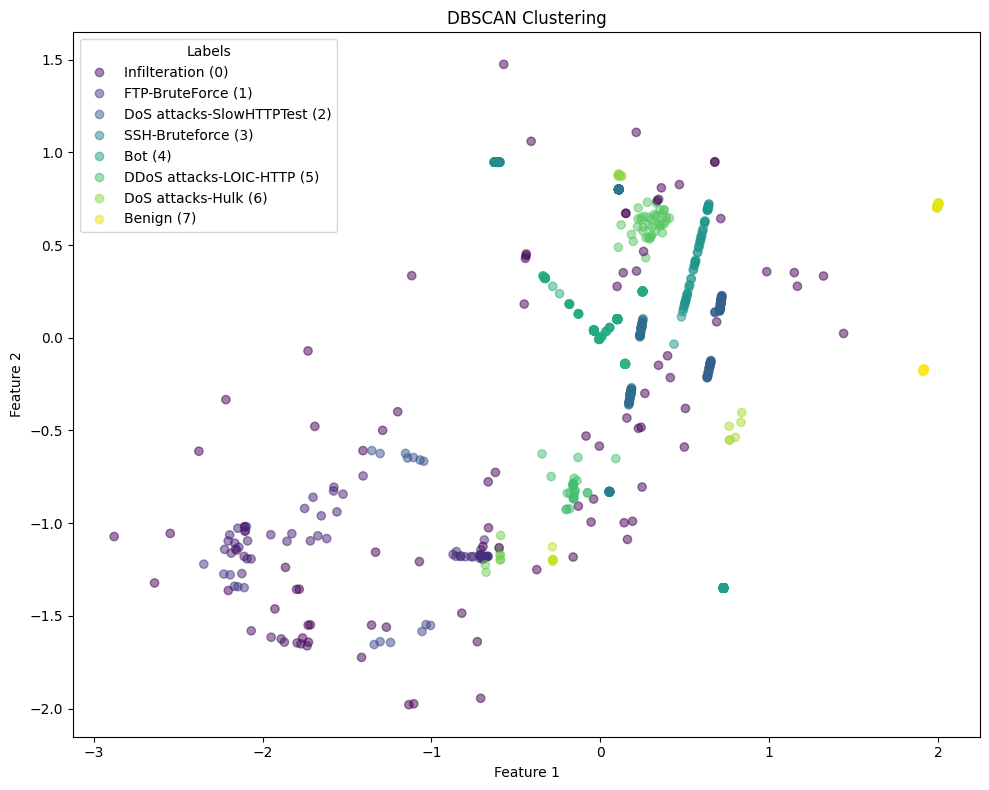

In [66]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Extract data from the dictionary
data = []
labels = []

for label, tensors in compressed_outs.items():
    for tensor in tensors:
        data.append(tensor.detach().numpy())
        labels.append(label)

data = np.array(data)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You may need to adjust eps and min_samples
cluster_labels = dbscan.fit_predict(data)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 8))

# Visualize the clusters with different colors for each label
scatter = ax.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)

# Add legend with label names only if there are valid elements
if scatter.legend_elements()[0] is not None and len(scatter.legend_elements()[0]) > 0:
    unique_labels = list(set(labels))
    legend_labels = [f'{label} ({i})' for i, label in enumerate(unique_labels)]
    ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Labels')

ax.set_title('DBSCAN Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.tight_layout()  # Adjust layout

plt.show()



In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = compressed_outs_test['Benign'][0].shape[0]
classify = len(compressed_outs.keys())

class GlobalModel(nn.Module):
    def __init__(self, input_dim):
        super(GlobalModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 69)
        self.fc4 = nn.Linear(69, classify)
       
        self.activation = nn.Tanh()
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)

        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        return x
global_model = GlobalModel(input_dim).to(device)

In [30]:
opt= torch.optim.Adam(global_model.parameters(), lr = 0.012, weight_decay=1e-05)

In [31]:
global_model

GlobalModel(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=69, bias=True)
  (fc4): Linear(in_features=69, out_features=9, bias=True)
  (activation): Tanh()
)

In [61]:
def global_update(global_model, optimizer, train_data, target_labels, epoch):
    for e in range(epoch):
        running_loss = 0.0
        prev = 0
        ind = 128
        for data in train_data:
          global_model.train()
          output = global_model(data.float()) # tensor 115
          optimizer.zero_grad()
          global_model.eval()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(device), output)
          target_label = torch.Tensor(target_labels[prev:ind])
          loss = nn.CrossEntropyLoss()(output, target_label)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
          prev = ind
          ind += 128
          if ind > len(target_labels):
            ind = len(target_labels)
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss



In [33]:
epochs = 100
batch_size = 128

In [34]:
import random

detached_tensors = []
detached_labels = []

# Iterate through the tensors and detach them
for key, tensor_list in compressed_outs.items():
    for tensor in tensor_list:
        detached_labels.append(dikt[key])
        dt = tensor.detach().numpy()  # Detach from computation graph and convert to NumPy array if needed
        detached_tensors.append(dt)

idxs = list(range(len(detached_tensors)))
# Shuffle the indices
idxs=shuffle(idxs)

# Use the indices to shuffle the tensors and labels
shuffled_tensors = [detached_tensors[i] for i in idxs] 
shuffled_labels = [detached_labels[i] for i in idxs]

shuffled_data_loader = DataLoader(shuffled_tensors, batch_size=batch_size)

In [35]:
loss=global_update(global_model, opt, shuffled_data_loader, shuffled_labels, epochs)

In [36]:
torch.save(global_model, 'modelsworking/globalattackmodel.pt')

In [51]:
global_model = torch.load('modelsworking/globalattackmodel.pt')

In [58]:
detached_tensors_test = []
detached_labels_test= []

# Iterate through the tensors and detach them
for key, tensor_list in compressed_outs_test.items():
    for tensor in tensor_list:
        detached_labels_test.append(dikt[key])
        dt = tensor.detach().numpy()  # Detach from computation graph and convert to NumPy array if needed
        detached_tensors_test.append(dt)

In [59]:
labels = []
for i in detached_labels_test:
    labels.append(i.index(1))
print(len(labels))

10368


<Axes: >

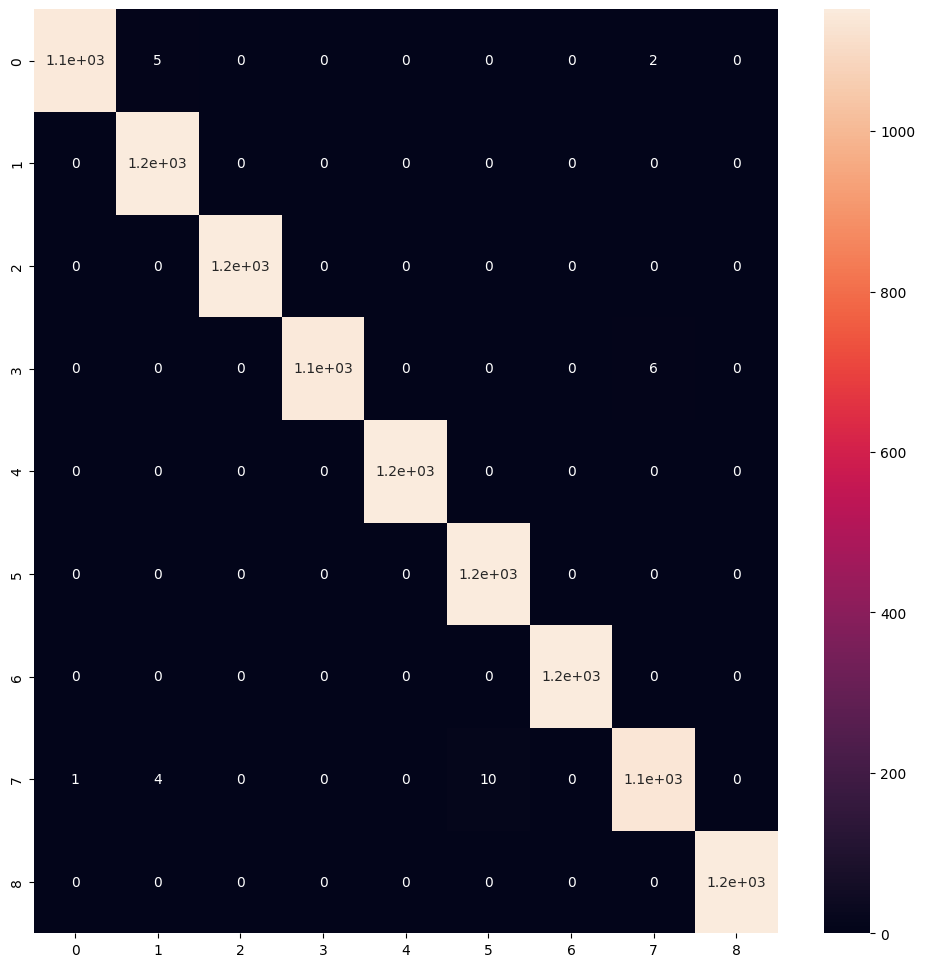

In [60]:
from sklearn.metrics import confusion_matrix
model = global_model
model.eval()
temp_test = []
temp = []
for data in detached_tensors_test:
    data = torch.Tensor(data).reshape(1,-1)
    pred = nn.Softmax(dim=1)(model(data).float())
    temp.append(pred)
    pred = pred.argmax(dim=1)
    temp_test.append(pred)
cm = confusion_matrix(labels, temp_test)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True)

In [40]:
import numpy as np

# Get total number of samples
total = np.sum(cm) 

# Per class metrics
diag = np.diag(cm)
precision = diag / np.sum(cm, axis=0)
recall = diag / np.sum(cm, axis=1)

# Overall metrics
accuracy = np.sum(diag) / total
misclassification = 1 - accuracy

K = len(cm) # number of classes 

# Metrics per class
TPR = np.diag(cm) / cm.sum(axis=1) 
FPR = (cm.sum(axis=0) - np.diag(cm)) / (cm.sum() - cm.sum(axis=1))

# Macro-averaged metrics
macro_TPR = np.mean(TPR)
macro_FPR = np.mean(FPR)

print('Accuracy:', accuracy)
print('Misclassification:', misclassification) 
print('Precision:', precision)
print('Recall:', recall)
print('Macro TPR:', macro_TPR)
print('Macro FPR:', macro_FPR)

Accuracy: 0.9972993827160493
Misclassification: 0.002700617283950657
Precision: [0.9991274  0.99224806 1.         1.         1.         0.99139415
 1.         0.9930131  1.        ]
Recall: [0.99392361 1.         1.         0.99479167 1.         1.
 1.         0.98697917 1.        ]
Macro TPR: 0.9972993827160495
Macro FPR: 0.00033757716049382714


In [41]:
"""
compressed_mixed = {}
for i in range(len(mixed_data_labels)):
    label = mixed_data_labels[i]
    model = client_models[label]
    model.eval()
    layer_output = model(torch.Tensor(mixed_data[i]))
    try:
        compressed_mixed[label].append(layer_output)
    except:
        compressed_mixed[label] = [layer_output]
"""

'\ncompressed_mixed = {}\nfor i in range(len(mixed_data_labels)):\n    label = mixed_data_labels[i]\n    model = client_models[label]\n    model.eval()\n    layer_output = model(torch.Tensor(mixed_data[i]))\n    try:\n        compressed_mixed[label].append(layer_output)\n    except:\n        compressed_mixed[label] = [layer_output]\n'

In [44]:
compressed_mixed = {}
for i in client_models:
    model = client_models[i]
    model.eval()
    for data in mixed_data:
        layer_output = model(torch.Tensor(data))    
        try:
            compressed_mixed[i].append(layer_output)
        except:
            compressed_mixed[i] = [layer_output]

In [45]:
"""
detached_tensors_mixed = []
detached_labels_mixed= mixed_data_labels_encoded*9

# Iterate through the tensors and detach them
for key, tensor_list in compressed_mixed.items():
    for tensor in tensor_list:
        dt = tensor.detach().numpy()  # Detach from computation graph and convert to NumPy array if needed
        detached_tensors_mixed.append(dt)
detached_data_mixed_loader = DataLoader(detached_tensors_mixed, batch_size=batch_size)

epochs = 50
loss=global_update(global_model, opt, detached_data_mixed_loader, detached_labels_mixed, epochs)
"""

In [55]:
global_model.eval()
preds = {}
for i in range(len(compressed_mixed['Bot'])):
    client_preds = []
    for key in compressed_mixed:
        data = compressed_mixed[key][i]
        data = torch.Tensor(data).reshape(1,-1)
        pred = nn.Softmax(dim=1)(global_model(data).float())
        client_preds.append(int(pred.argmax(dim=1)))
    preds[i] = client_preds

In [56]:
x = 4
preds[x], mixed_data_labels_encoded[x].index(1)

([0, 1, 5, 3, 4, 5, 6, 7, 8], 6)

In [62]:
from collections import Counter
for i in preds:
    print(Counter(preds[i]).most_common(1)[0][0], detached_labels_mixed[i].index(1))

5 5
5 6
0 0
0 8
5 6
0 1
0 8
5 6
0 0
0 4
5 6
0 3
0 4
6 0
0 3
0 4
0 3
0 8
5 5
0 8
0 7
0 0
5 5
0 3
5 5
0 0
6 0
0 7
0 1
0 3
5 7
5 7
0 0
0 1
5 5
5 5
5 7
0 2
5 0
5 7
0 0
0 4
0 3
0 3
0 3
5 7
5 5
6 0
0 0
0 2
6 0
5 5
0 3
5 6
0 0
7 0
0 2
0 8
5 6
0 0
0 2
7 1
0 2
0 2
5 5
7 1
0 2
0 8
0 0
0 0
1 7
0 0
0 2
1 7
0 1
0 8
0 7
0 0
0 4
5 5
5 5
6 0
5 5
5 0
0 2
0 3
1 2
0 7
0 4
0 2
7 1
0 8
0 8
0 0
0 8
1 2
0 3
0 8
0 7
0 3
0 7
0 0
5 5
5 5
5 5
0 3
5 6
0 7
0 7
0 3
0 3
0 7
0 7
0 3
0 8
0 4
0 8
0 7
0 4
5 6
0 4
0 4
0 3
0 4
7 1
0 4
1 2
5 6
0 2
0 0
0 4
0 8
0 3
5 6
0 0
0 4
5 6
0 3
0 4
0 3
0 7
1 7
0 4
5 0
1 7
0 7
0 7
0 0
1 2
5 6
0 1
0 0
0 0
0 7
0 3
0 2
5 5
0 0
0 1
5 6
0 4
5 5
0 4
0 1
5 5
5 6
5 6
0 3
7 0
5 6
0 7
0 4
0 4
5 5
0 4
0 1
0 4
0 7
5 5
5 5
5 5
5 6
6 0
5 7
5 0
0 3
0 8
0 2
0 4
5 6
5 5
5 6
5 6
0 2
0 7
0 1
5 5
5 6
0 7
0 3
0 8
0 8
5 7
0 8
5 0
5 5
0 2
6 0
5 6
0 4
0 2
7 0
0 1
0 7
0 4
0 3
5 6
5 0
0 4
0 2
1 2
5 6
0 3
0 4
5 7
0 7
0 1
0 4
5 5
5 5
0 2
0 7
0 3
0 3
0 4
5 0
0 8
0 0
0 7
5 5
0 4
0 8
0 2
5 6
5 6
6 0
7 1
6 0
0 2
0 3


In [213]:
import numpy as np

# Get total number of samples
total = np.sum(cm) 

# Per class metrics
diag = np.diag(cm)
precision = diag / np.sum(cm, axis=0)
recall = diag / np.sum(cm, axis=1)

# Overall metrics
accuracy = np.sum(diag) / total
misclassification = 1 - accuracy

K = len(cm) # number of classes 

# Metrics per class
TPR = np.diag(cm) / cm.sum(axis=1) 
FPR = (cm.sum(axis=0) - np.diag(cm)) / (cm.sum() - cm.sum(axis=1))

# Macro-averaged metrics
macro_TPR = np.mean(TPR)
macro_FPR = np.mean(FPR)

print('Accuracy:', accuracy)
print('Misclassification:', misclassification) 
print('Precision:', precision)
print('Recall:', recall)
print('Macro TPR:', macro_TPR)
print('Macro FPR:', macro_FPR)

Accuracy: 0.996045524691358
Misclassification: 0.003954475308642014
Precision: [0.99913043 0.9974026  1.         0.98958333 1.         0.99567848
 0.98545766 0.99734278 1.        ]
Recall: [0.99739583 1.         1.         0.98958333 1.         1.
 1.         0.97743056 1.        ]
Macro TPR: 0.996045524691358
Macro FPR: 0.0004943094135802469
